### Prediccion de Diabetes utilizando un perceptron simple

Un perceptrón en IA es la unidad básica de una red neuronal. Con Keras, es un modelo de red neuronal de una sola capa con una función de activación. Toma entradas ponderadas, las suma y aplica una función de activación para producir una salida.

Un perceptrón consta de entradas (features), pesos (synaptic weights), una suma ponderada, un sesgo (bias), una función de activación y una salida. Cada entrada se multiplica por su peso correspondiente, se suman, se agrega el sesgo y se pasa a través de la función de activación. La función de activación introduce no linealidades, permitiendo que el perceptrón aprenda patrones más complejos. En términos de teoría, los perceptrones son bloques fundamentales de las redes neuronales, y al agrupar múltiples perceptrones, se pueden modelar relaciones más sofisticadas y resolver problemas complejos. La capacidad de ajustar pesos durante el entrenamiento permite al perceptrón aprender de los datos y mejorar su rendimiento en tareas específicas.

--------------------------------------------------

Importamos las librerias que vamos a utilizar

In [31]:
import numpy as np 
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
#from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

Comentamos esta linea de código debido a que solo se utiliza si estamos en un entorno como Google Colab

In [32]:
#uploaded = files.upload()

En caso de trabajar en un entorno local utilizamos esta linea que importa el dataset desde la raíz de la carpeta.

In [33]:
dataset = pd.read_csv("diabetes-2.csv", encoding="utf-8")


Visualizamos los datos de la tabla en forma de media, desviacion estandar, minimos, cuartiles y maximo

In [34]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Seleccionamos las columnas que vamos a utilziar

In [35]:
valores_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def revisar_los_valores_zero(data, fields):

    for field in fields:
        print('Campos %s: con entradas en 0: %d' % (field, len(data.loc[ data[field] == 0, field ])))

revisar_los_valores_zero(dataset, valores_zero)

Campos Glucose: con entradas en 0: 5
Campos BloodPressure: con entradas en 0: 35
Campos SkinThickness: con entradas en 0: 227
Campos Insulin: con entradas en 0: 374
Campos BMI: con entradas en 0: 11


Utilizamos un conjunto de datos con características ('features') y la variable objetivo 'Outcome'. Se divide el conjunto en entrenamiento y prueba (75% entrenamiento, 25% prueba) usando `train_test_split` de scikit-learn. Luego, se imprime la longitud de los conjuntos de entrenamiento y prueba. 

In [36]:
features = list(dataset.columns.values)
features.remove('Outcome')
print(features)
X = dataset[features]
y = dataset['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Longitud de entrenamiento" , X_train.shape)
print("Longitud de prueba" , X_test.shape)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Longitud de entrenamiento (576, 8)
Longitud de prueba (192, 8)


Calculamos el promedio de los valores no cero en ese campo y lo utiliza para reemplazar los ceros. Luego, imprime un mensaje indicando el campo, la cantidad de entradas actualizadas y el nuevo valor promedio.

In [37]:
def rellenar_valores_zeros(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = np.sum(nonzero_vals) / len(nonzero_vals)
    k = len(data.loc[ data[field] == 0, field])
    data.loc[ data[field] == 0, field ] = avg
    print('En el campo: %s;  fueron actualizadas %d entradas con el valor: %.3f' % (field, k, avg))

for campo in valores_zero:
    rellenar_valores_zeros(X_train, campo)

En el campo: Glucose;  fueron actualizadas 4 entradas con el valor: 122.003
En el campo: BloodPressure;  fueron actualizadas 25 entradas con el valor: 72.846
En el campo: SkinThickness;  fueron actualizadas 163 entradas con el valor: 29.465
En el campo: Insulin;  fueron actualizadas 270 entradas con el valor: 158.464
En el campo: BMI;  fueron actualizadas 8 entradas con el valor: 32.663


Dejamos solo los valores, y no los nombres de la columna

In [38]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

La primera capa tiene 32 nodos con activación ReLU y 8 dimensiones de entrada. La segunda capa tiene 16 nodos con activación ReLU. La capa de salida tiene 1 nodo con activación sigmoide para problemas de clasificación binaria. Utiliza el optimizador 'adam' y la función de pérdida 'binary_crossentropy'. Entrena el modelo con los datos de entrenamiento (X_train y y_train) durante 250 épocas.  

In [39]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = 8))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 250)

Epoch 1/250


18/18 [==============================] - 0s 1ms/step - loss: 2.4373 - accuracy: 0.5573
Epoch 2/250
18/18 [==============================] - 0s 882us/step - loss: 2.0886 - accuracy: 0.5764
Epoch 3/250
18/18 [==============================] - 0s 823us/step - loss: 1.5155 - accuracy: 0.5972
Epoch 4/250
18/18 [==============================] - 0s 882us/step - loss: 1.1574 - accuracy: 0.5955
Epoch 5/250
18/18 [==============================] - 0s 824us/step - loss: 1.0933 - accuracy: 0.6076
Epoch 6/250
18/18 [==============================] - 0s 824us/step - loss: 1.0003 - accuracy: 0.6302
Epoch 7/250
18/18 [==============================] - 0s 765us/step - loss: 0.9335 - accuracy: 0.6319
Epoch 8/250
18/18 [==============================] - 0s 823us/step - loss: 0.7781 - accuracy: 0.6441
Epoch 9/250
18/18 [==============================] - 0s 823us/step - loss: 0.7222 - accuracy: 0.6458
Epoch 10/250
18/18 [==============================] - 0s 823us/step - loss: 0.7633 - accuracy: 0.6424
Epo

Puntuacion

In [40]:
scores = model.evaluate(X_train, y_train )
print("Precision Entrenamiento: %.2f%%\n" % (scores[1] * 100))
scores = model.evaluate(X_test, y_test)
print("Precision Prueba: %.2f%%\n" % (scores[1] * 100))

18/18 [==============================] - 0s 882us/step - loss: 0.4665 - accuracy: 0.7847
Precision Entrenamiento: 78.47%

6/6 [==============================] - 0s 1000us/step - loss: 3.5386 - accuracy: 0.6719
Precision Prueba: 67.19%



In [41]:
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()
print(p_pred.round(2))



y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)



print(classification_report(y_test, y_pred))

6/6 [==============================] - 0s 800us/step
[0.   0.17 0.   0.69 0.   0.02 0.68 0.83 0.48 0.5  0.35 0.86 0.   0.42
 0.   0.   0.86 0.   0.   0.52 0.   0.   0.   0.   0.09 0.01 0.   0.87
 0.   0.   0.49 0.18 0.06 0.67 0.64 0.   0.6  0.03 0.87 1.   0.5  0.
 0.02 0.   0.89 0.   0.31 0.48 0.47 0.   0.   0.61 0.84 0.02 0.2  0.47
 0.   0.   0.   0.   0.31 0.38 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.01 0.   0.   0.   0.   0.67 0.   0.03 0.   0.19 0.25 0.08
 0.05 0.   0.   0.6  0.84 0.29 0.   0.   0.63 0.03 0.01 0.71 0.24 0.21
 0.64 0.   0.19 0.37 0.   0.04 0.35 0.   0.06 0.01 0.01 0.   0.32 0.29
 0.   0.06 0.33 0.   0.19 0.81 0.   0.7  0.01 0.   0.42 0.   0.71 0.
 0.19 0.   0.   0.   0.54 0.   0.   0.77 0.01 0.01 0.   0.12 0.   0.
 0.06 0.78 0.   0.   0.   0.   0.03 0.   0.   0.11 0.03 0.   0.16 0.18
 0.5  0.   0.4  0.31 0.   0.   0.72 0.   0.2  0.49 0.   0.   0.   0.
 0.   0.   0.49 0.   0.   0.   0.   0.13 0.   0.   0.17 0.   0.   0.
 0.15 0.   0.   0.   0.   0.   0.65 

Crearemos una matriz de confusion para poder visualizar la cantidad de verdaderos positivos, falsos positivos, falsos negativos , falsos verdaderos

In [42]:
mapa_calor = confusion_matrix(y_test, y_pred)

<Axes: >

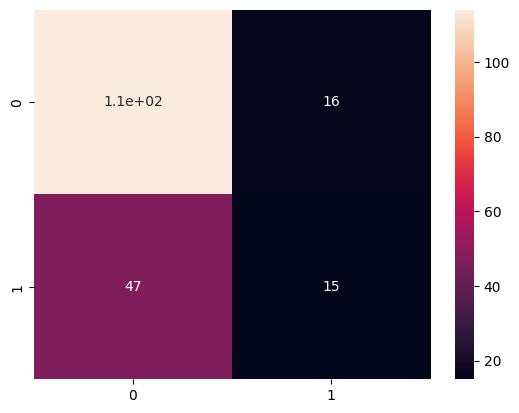

In [43]:
sn.heatmap(mapa_calor, annot=True)